In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils import segment2path, pairwise_distances

In [2]:
record_dir = 'motor_robustness/lamb'
var_name = 'noise_motor'
ls_value = 0, 0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50
n_condition = len(ls_value)

In [3]:
n_trial = 100
n_epoch_train, n_epoch_test = 125, 500

In [4]:
ls_color = plt.rcParams["axes.prop_cycle"].by_key()["color"]

## path data

In [5]:
data_path_train, data_path_test = [], []
data_dist_init2goal, data_mindist_test2goal, data_time_mindist_test2goal, data_dsim_test2train = [], [], [], []

for val in ls_value:
    data_dir = os.path.join('records', record_dir, '{}{}'.format(var_name, val))
    for trial_dir in os.listdir(data_dir):
        path = {'test': None, 'train': None}
        ### load path data
        for phase in ('train', 'test'):
            data_file = os.path.join(data_dir, trial_dir, 'Freight_{}_0_record.npz'.format(phase))
            try:
                path[phase] = np.transpose([np.load(data_file)[arg] for arg in 'xy'])
            except:
                print("The file {} does not exist.".format(data_file))
        
        ### process path data
        path_train_init, path_train_goal = path['train'][[0, -1]]
        
        dist_init2goal = np.linalg.norm(path_train_goal - path_train_init)
        dist_test2goal = np.linalg.norm(path_train_goal - path['test'], axis=1)
        time_mindist_test2goal = np.argmin(dist_test2goal)
        mindist_test2goal = dist_test2goal[time_mindist_test2goal]
        
        dist_test2goal[time_mindist_test2goal + 1:] = np.nan
        path['test'][time_mindist_test2goal + 1:] = np.nan
        dsim_test2train = segment2path(path['test'][:time_mindist_test2goal + 1], path['train'])

        ### collect data
        data_path_train.append(path['train'].T)
        data_path_test.append(path['test'].T)
        data_dist_init2goal.append(dist_init2goal)
        data_mindist_test2goal.append(mindist_test2goal)
        data_time_mindist_test2goal.append(time_mindist_test2goal)
        data_dsim_test2train.append(dsim_test2train)
        
### reshape data
data_path_train, data_path_test = [np.reshape(dt, (n_condition, n_trial, 2, -1)) 
                                   for dt in (data_path_train, data_path_test)]
data_dist_init2goal, data_mindist_test2goal, data_time_mindist_test2goal, data_dsim_test2train = [np.reshape(dt, (n_condition, n_trial)) 
                                                                                                  for dt in (data_dist_init2goal, data_mindist_test2goal, data_time_mindist_test2goal, data_dsim_test2train)]

## progress

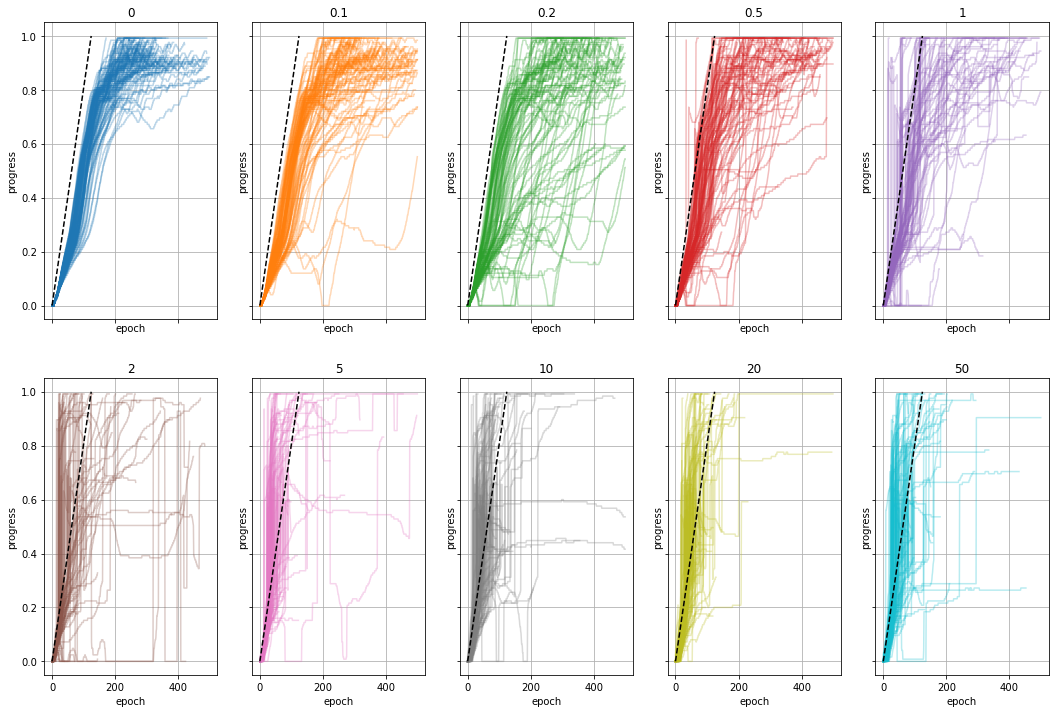

In [6]:
fig, axes = plt.subplots(2, n_condition // 2, sharex=True, sharey=True, figsize=(18, 12))
for dtt, dtp_train, dtp_test, val, ax, color in zip(data_time_mindist_test2goal, data_path_train, data_path_test, ls_value, axes.flatten(), ls_color):
    for trial_idx, (time_mindist_test2goal, path_train, path_test) in enumerate(zip(dtt, dtp_train, dtp_test)):
        if trial_idx % 1 == 0:
            test2train = pairwise_distances(path_test.T[:time_mindist_test2goal + 1], path_train.T)
            progress = np.argmin(test2train, axis=0) / n_epoch_train
            ax.plot(progress, c=color, alpha=0.3)
    
    ax.plot([0, n_epoch_train - 1], [0, 1], c='k', ls='dashed')
    ax.set_xlabel('epoch')
    ax.set_ylabel('progress')
    ax.set_title(val)
    ax.grid()

## trajectories

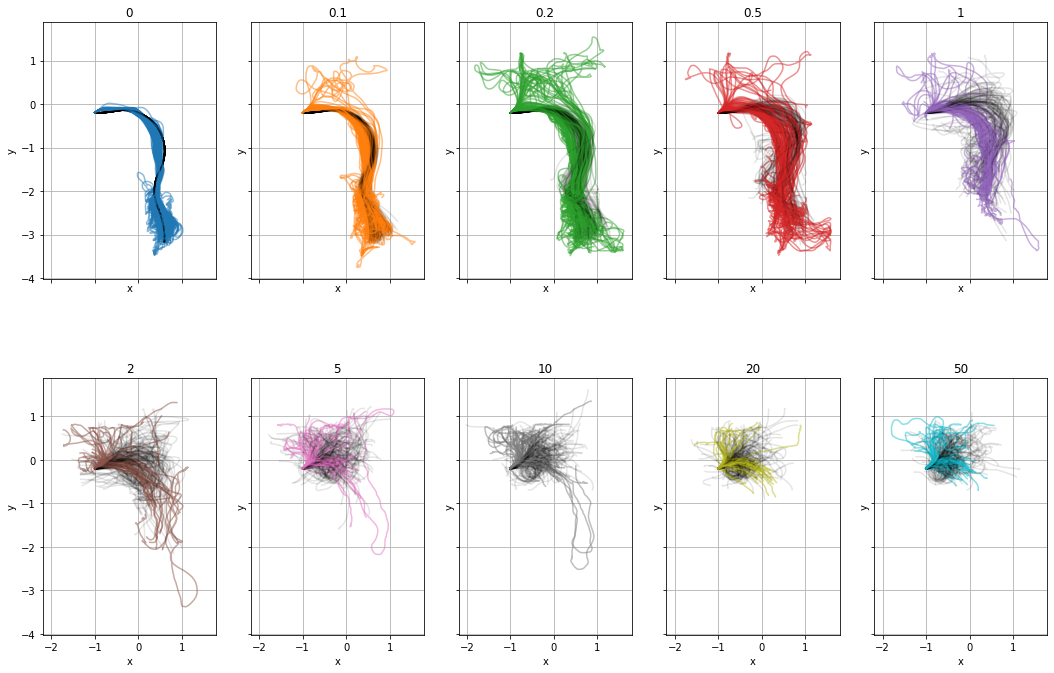

In [13]:
fig, axes = plt.subplots(2, n_condition // 2, sharex=True, sharey=True, figsize=(18, 12))
for dtp_train, dtp_test, val, ax, color in zip(data_path_train, data_path_test, ls_value, axes.flatten(), ls_color):
    for trial_idx, (path_train, path_test) in enumerate(zip(dtp_train, dtp_test)):
        if trial_idx % 1 == 0:
            ax.plot(*path_train, c='k', alpha=0.1)
            ax.plot(*path_test, c=color, alpha=0.5)
        
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_aspect('equal')    
    ax.set_title(val)
    ax.grid()

## minimal distance to goal

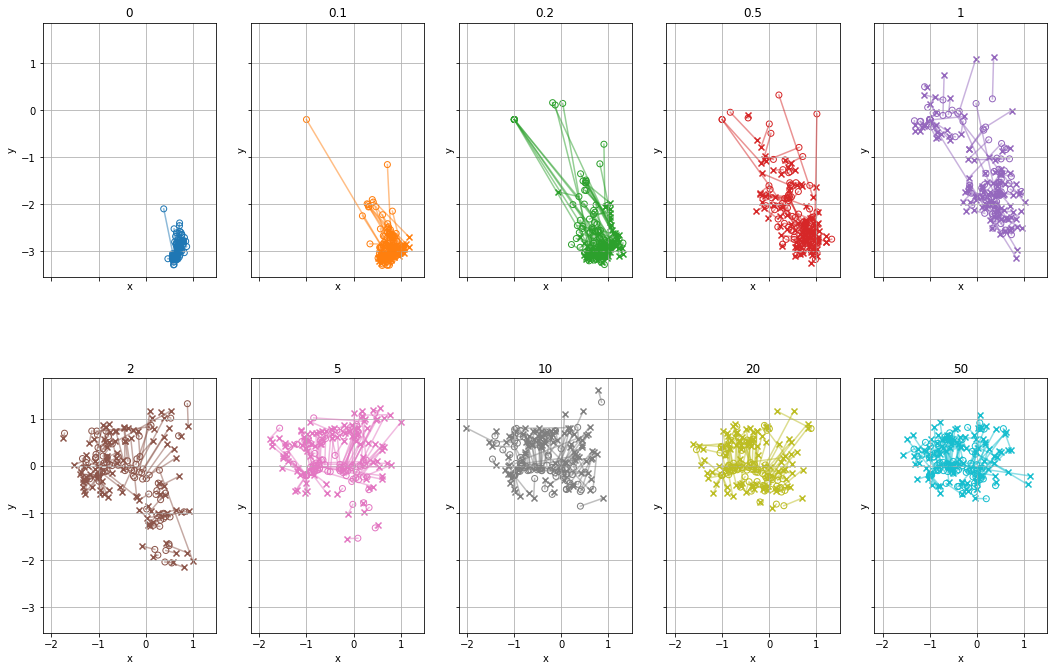

In [8]:
fig, axes = plt.subplots(2, n_condition // 2, sharex=True, sharey=True, figsize=(18, 12))
for dtp_train, dtp_test, dtt, val, ax, color in zip(data_path_train, data_path_test, data_time_mindist_test2goal, ls_value, axes.flatten(), ls_color):
    for trial_idx, (path_train, path_test, time_mindist_test2goal) in enumerate(zip(dtp_train, dtp_test, dtt)):
        if trial_idx % 1 == 0:
            ax.plot(*np.transpose([path_train.T[-1], path_test.T[time_mindist_test2goal]]), c=color, alpha=0.5)
            ax.scatter(*path_train[:, -1], marker='x', color=color)
            ax.scatter(*path_test[:, time_mindist_test2goal], marker='o', edgecolor=color, facecolor='none')
    
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_aspect('equal')    
    ax.set_title(val)
    ax.grid()

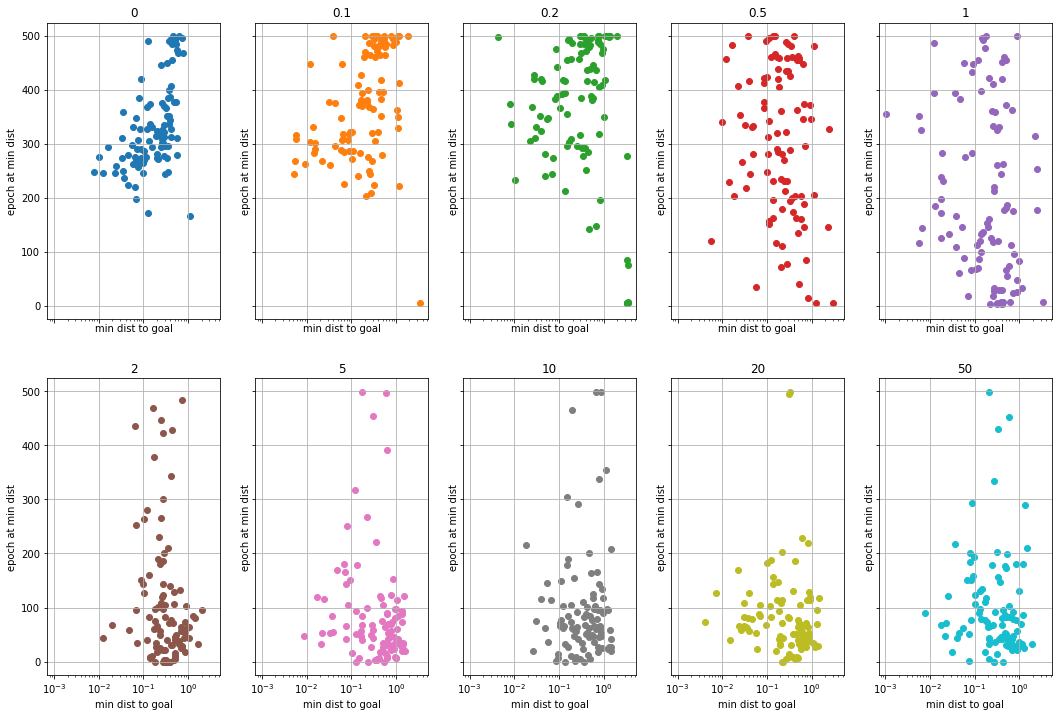

In [9]:
fig, axes = plt.subplots(2, n_condition // 2, sharex=True, sharey=True, figsize=(18, 12))
for dtt, dtmd, val, ax, color in zip(data_time_mindist_test2goal, data_mindist_test2goal, ls_value, axes.flatten(), ls_color):
    ax.scatter(dtmd, dtt, color=color)
    
    ax.set_xlabel('min dist to goal')
    ax.set_ylabel('epoch at min dist')
    ax.set_xscale('log')
    ax.set_title(val)
    ax.grid()

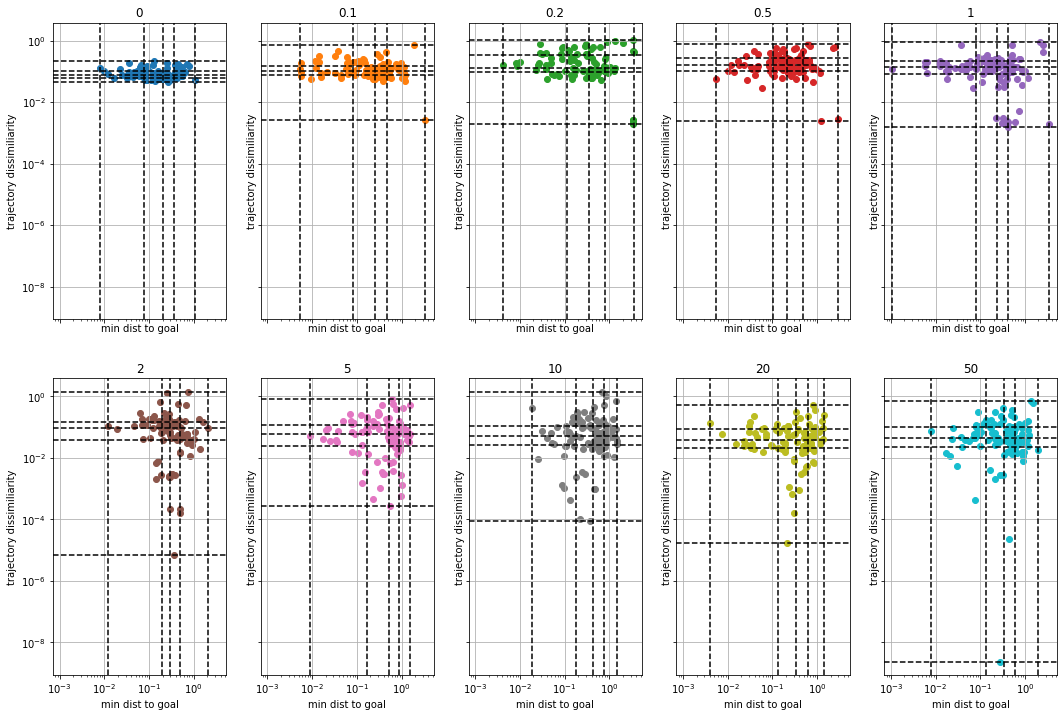

In [10]:
fig, axes = plt.subplots(2, n_condition // 2, sharex=True, sharey=True, figsize=(18, 12))

quantile_mindist_test2goal, quantile_dsim_test2train = [], []
for dsim, dtmd, val, ax, color in zip(data_dsim_test2train, data_mindist_test2goal, ls_value, axes.flatten(), ls_color):
    quantile_mindist_test2goal.append(np.quantile(dtmd, [0, 0.25, 0.5, 0.75, 1]))
    quantile_dsim_test2train.append(np.quantile(dsim, [0, 0.25, 0.5, 0.75, 1]))
    
    [ax.axvline(mdq, color='k', ls='dashed') for mdq in quantile_mindist_test2goal[-1]]    
    [ax.axhline(mdq, color='k', ls='dashed') for mdq in quantile_dsim_test2train[-1]]
    ax.scatter(dtmd, dsim, color=color)
    
    ax.set_xlabel('min dist to goal')
    ax.set_ylabel('trajectory dissimiliarity')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title(val)
    ax.grid()

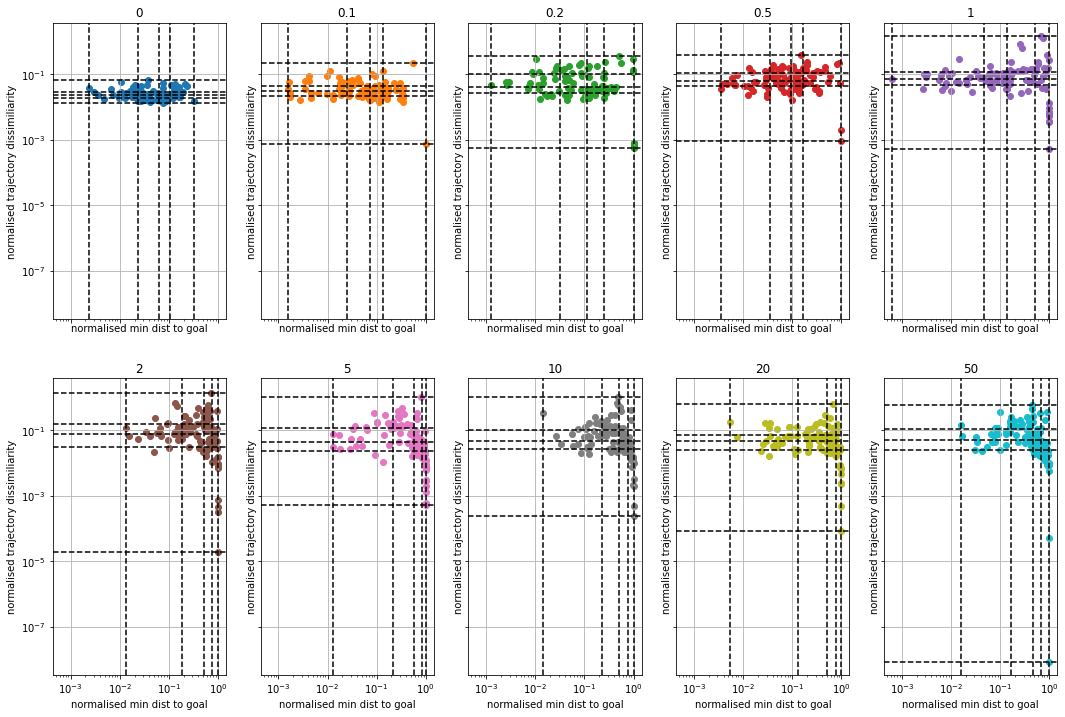

In [11]:
fig, axes = plt.subplots(2, n_condition // 2, sharex=True, sharey=True, figsize=(18, 12))

quantile_norm_mindist_test2goal, quantile_norm_dsim_test2train = [], []
for dti, dsim, dtmd, val, ax, color in zip(data_dist_init2goal, data_dsim_test2train, data_mindist_test2goal, ls_value, axes.flatten(), ls_color):
    norm_dtmd, norm_dsim = np.divide(dtmd, dti), np.divide(dsim, dti)
    quantile_norm_mindist_test2goal.append(np.quantile(norm_dtmd, [0, 0.25, 0.5, 0.75, 1]))
    quantile_norm_dsim_test2train.append(np.quantile(norm_dsim, [0, 0.25, 0.5, 0.75, 1]))
    
    [ax.axvline(mdq, color='k', ls='dashed') for mdq in quantile_norm_mindist_test2goal[-1]]    
    [ax.axhline(mdq, color='k', ls='dashed') for mdq in quantile_norm_dsim_test2train[-1]]
    ax.scatter(norm_dtmd, norm_dsim, color=color)
    
    ax.set_xlabel('normalised min dist to goal')
    ax.set_ylabel('normalised trajectory dissimiliarity')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title(val)
    ax.grid()

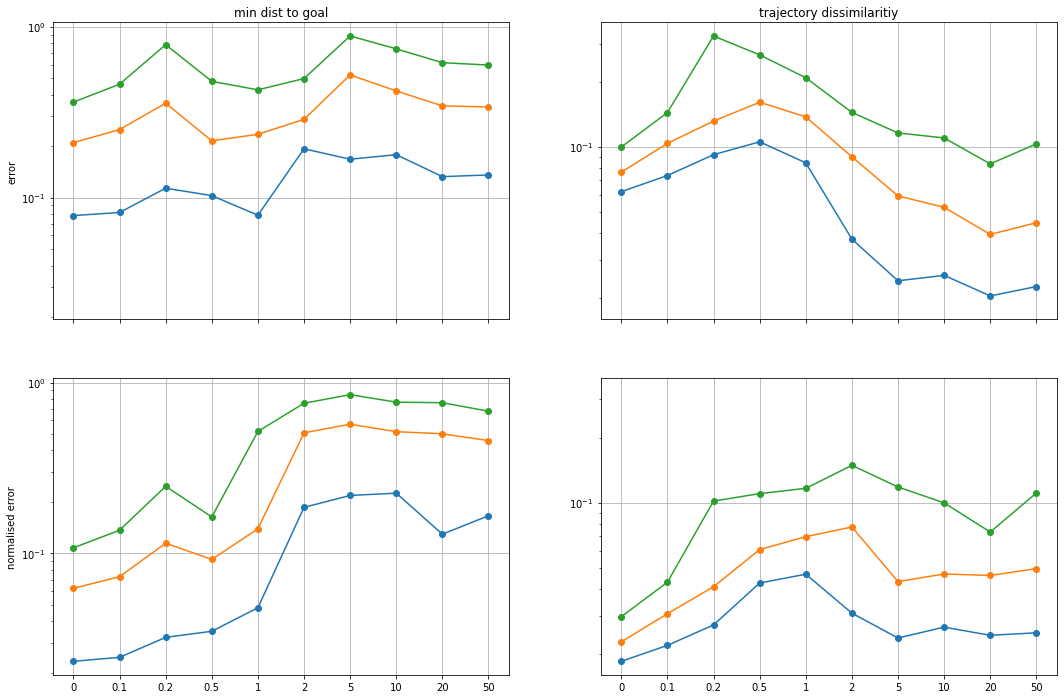

In [12]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey='col', figsize=(18, 12))

for ax, q in zip(axes.flatten(),
                 (quantile_mindist_test2goal, quantile_dsim_test2train, 
                  quantile_norm_mindist_test2goal, quantile_norm_dsim_test2train)):
    ax.plot(np.arange(n_condition), np.array(q)[:, 1:-1], marker='o')
    
    ax.set_yscale('log')
    ax.set_xticks(np.arange(n_condition), labels=ls_value)
    ax.grid()
    
for ax, title in zip(axes[0], ('min dist to goal', 'trajectory dissimilaritiy')):
    ax.set_title(title)
    
for ax, ylabel in zip(axes.T[0], ('error', 'normalised error')):
    ax.set_ylabel(ylabel)